In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# A Hands-On Tutorial on AI Fairness and AI Explainability Using Open-Source Libraries

**Overview**

Due to the increasing use of machine learning models in high-stakes applications, it is very important to go beyond traditional metrics, such as accuracy or AUC-ROC, and evaluate models along other dimensions, such as fairness, explainability, adversarial robustness, and privacy. In this tutorial, we show how two open-source libraries can be used to evaluate models along two important dimensions - fairness and explainability.


**Dataset**

For this lab, we will use mortgage application data collected in the U.S. under the Home Mortgage Disclosure Act - specifically, the 2018 snapshot national loan level dataset (https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2018). The actual data used is a sample extracted from the above dataset and cleaned/processed for the purpose of this tutorial.


**Problem**

We pose the problem as one of binary classification i.e. predict whether a mortgage is approved or not

**Open source libraries used**

We use three Trusted AI open source libraries<br>
(1) Fairness: AI Fairness 360 or AIF360 (https://github.com/Trusted-AI/AIF360)<br>
(2) Explainability: AI Explainability 360 or AIX 360 (https://github.com/Trusted-AI/AIX360)<br>


# Libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sys
sys.path.append("../")
%matplotlib inline

from numpy.random import seed
seed(42)

from IPython.display import Markdown, display

import os, types
import warnings
#import pentathlon

warnings.filterwarnings("ignore")

# visualization, data wrangling, matrix operations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

# model training, evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score

#Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


#save models
import pickle

pd.set_option("display.max_columns",200)
pd.set_option("display.max_rows",200)



# Lets take a look at the data

In [3]:
df_data = pd.read_csv("2018_hmda_mortgage_approval_processed_TRAIN_small.csv")

In [4]:
df_data.head()

,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,purchaser_type,preapproval,loan_amount,combined_loan_to_value_ratio,loan_term,intro_rate_period,other_nonamortizing_features,property_value,total_units,income,debt_to_income_ratio,applicant_credit_score_type,applicant_age,applicant_age_above_62,initially_payable_to_institution,aus_1,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,derived_race_ethnicity_combination,loan_approved,gender,modified_debt_to_income_ratio
0,549300HW662MN1WU8550,41740,CA,6073.0,6.073001e+09,C,1,2,255000.0,85.00,360,NaN,2,305000.0,1,90.0,44,2,25-34,No,2,1,3545,42.74,81800,69,435,857,46,Non-Hispanic White,True,Female,44.0
1,254900O723MCLR701H50,16974,IL,17031.0,1.703181e+10,C,71,2,175000.0,80.00,360,NaN,2,225000.0,1,61.0,40,3,25-34,No,1,1,4579,23.91,82400,163,1188,587,76,Non-Hispanic White,True,Male,40.0
2,549300ZUZB0H1M5M3I66,99999,MS,28161.0,2.816195e+10,C,1,2,105000.0,80.00,180,NaN,2,135000.0,1,139.0,47,2,35-44,No,1,1,3241,38.60,47000,99,1060,1822,35,Non-Hispanic White,True,Male,47.0
3,549300D0TGZMG03GNM36,19804,MI,26163.0,2.616357e+10,C,9,2,95000.0,80.00,360,NaN,2,125000.0,1,37.0,20%-<30%,3,35-44,No,1,1,4971,9.45,55500,60,704,1559,74,Non-Hispanic White,True,Male,25.0
4,549300TUQC6OYE8A0Y96,19740,CO,8035.0,8.035014e+09,C,72,2,305000.0,64.52,360,NaN,2,465000.0,1,64.0,49,3,>74,Yes,1,1,5098,9.89,89900,163,1789,2003,19,Non-Hispanic White,True,Male,49.0


We look at two sensitive features in the data: 'gender' and 'derived_race_ethnicity_combination'. The target of interest is 'loan_approved'

<AxesSubplot:>

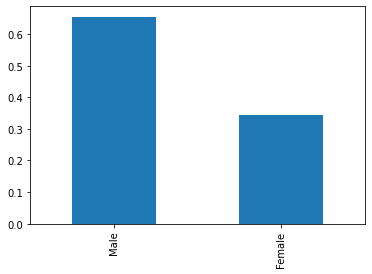

In [5]:
df_data['gender'].value_counts(normalize=True).plot(kind='bar')

The gender is split roughly 65% Male, 35% Female

<AxesSubplot:>

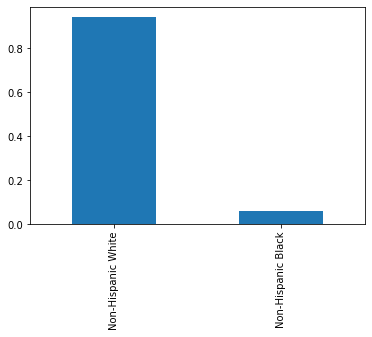

In [6]:
df_data['derived_race_ethnicity_combination'].value_counts(normalize=True).plot(kind='bar')

Race is appx. 95% White, 5% Black

<AxesSubplot:>

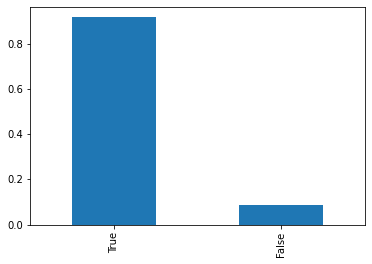

In [7]:
df_data['loan_approved'].value_counts(normalize=True).plot(kind='bar')

Around 91.5% of the applicants have their mortgage approved

<AxesSubplot:xlabel='derived_race_ethnicity_combination'>

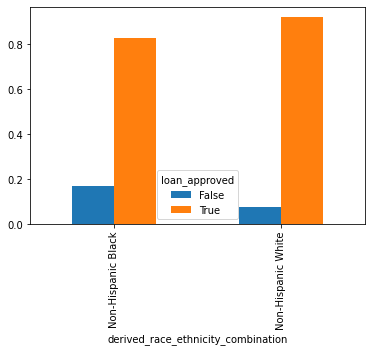

In [8]:
pd.crosstab(df_data['derived_race_ethnicity_combination'],df_data['loan_approved'],  normalize='index').plot(kind='bar')

For (Non-Hispanic) White applicants, the mortgage approval rate is appx. 92%. For (Non-Hispanic) Black applicants, the mortgage approal rate is appx. 83%.

<AxesSubplot:xlabel='gender'>

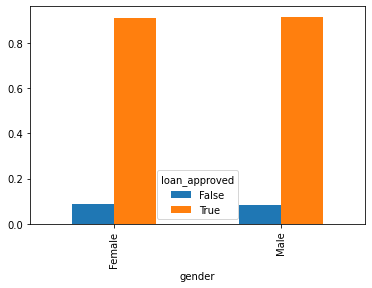

In [9]:
pd.crosstab(df_data['gender'],df_data['loan_approved'],  normalize='index').plot(kind='bar')

Mortgage approval rates by gender are almost the same - 92% for Males, 91% for Females

# Split data into test/train and look at different forms of data that can be used with the toolkits

In [10]:
cat = ['conforming_loan_limit','preapproval','loan_term',
      'aus_1', 'applicant_age', 'applicant_credit_score_type']
num = ['combined_loan_to_value_ratio', 'property_value', 'income', 'modified_debt_to_income_ratio',
      'loan_amount']

prot_attrs_names = ['derived_race_ethnicity_combination', 'gender']

In [11]:
df_data_train, df_data_test = train_test_split(df_data, test_size = .3, random_state=42)

### Option 1: Original AIF360 dataset object
#### Original API requires one to define/create a BinaryLabelDataSet or StandardDataset object. The object created is all numeric (categorical features are one-hot encoded), and protected_features/label are mapped to 0/1s.

In [12]:
from aif360.datasets import StandardDataset
sd_train = df_data_train.copy()
sd_test = df_data_test.copy()
sd_train = StandardDataset(df=sd_train, label_name='loan_approved', favorable_classes=[True], protected_attribute_names=['derived_race_ethnicity_combination', 'gender'], privileged_classes=[['Non-Hispanic White'],['Male']], categorical_features = cat, features_to_keep=cat+num+prot_attrs_names)
sd_test = StandardDataset(df=sd_test, label_name='loan_approved', favorable_classes=[True], protected_attribute_names=['derived_race_ethnicity_combination', 'gender'], privileged_classes=[['Non-Hispanic White'],['Male']], categorical_features = cat, features_to_keep=cat+num+prot_attrs_names)
sd_test = sd_train.align_datasets(sd_test)

#### Now use the StandardDataset object to check the training data for bias by computing the statistical_parity_difference metric

In [13]:
from aif360.metrics import BinaryLabelDatasetMetric
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]
metric_orig_train = BinaryLabelDatasetMetric(sd_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.004764


### Option 2: Pandas dataframe
#### Alternatively, do the conversions manually - one hot categorical and map protected featutes/labels to 0/1. However, you will need to convert to BinaryLabelDataset later

In [14]:
df_train = df_data_train.copy()
df_test = df_data_test.copy()


from sklearn.preprocessing import OneHotEncoder

gender_map = {'Male': 1.0, 'Female':0.0}
df_train.replace({'gender': gender_map}, inplace=True)
df_test.replace({'gender': gender_map}, inplace=True)

race_map = {'Non-Hispanic White': 1.0, 'Non-Hispanic Black':0.0}
df_train.replace({'derived_race_ethnicity_combination': race_map}, inplace=True)
df_test.replace({'derived_race_ethnicity_combination': race_map}, inplace=True)

df_train_cat = df_train[cat]
df_test_cat = df_test[cat]
enc = OneHotEncoder(sparse=False)

df_train_cat = pd.DataFrame(enc.fit_transform(df_train_cat), columns=enc.get_feature_names(cat), index=df_train_cat.index)
df_test_cat = pd.DataFrame(enc.transform(df_test_cat), columns=enc.get_feature_names(cat), index=df_test_cat.index)

# dum = pd.get_dummies(data[cat].astype('category'),prefix_sep='=')
X_train  = pd.concat([df_train_cat, df_train[num], df_train[prot_attrs_names]], axis=1)
X_test  = pd.concat([df_test_cat, df_test[num], df_test[prot_attrs_names]], axis=1)

y_train = pd.DataFrame(np.array((df_train['loan_approved'] == True) + .0),columns=['loan_approved'], index=df_train.index)
y_test = pd.DataFrame(np.array((df_test['loan_approved'] == True) + .0),columns=['loan_approved'], index=df_test.index)


#### Now create a BinaryLabelDataset object with the numerical, binarized data and compute statistical parity difference

In [15]:
from aif360.datasets import BinaryLabelDataset, StandardDataset

orig_data = X_train.copy()
orig_data['target'] = y_train.copy()
        
# create "BinaryLabelDataset" and "BinaryLabelDatasetMetric" class instances
orig_df = BinaryLabelDataset(df=orig_data, label_names=['target'], protected_attribute_names=['gender'])

privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]
metric_orig_train = BinaryLabelDatasetMetric(orig_df, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.004764


### Option 3: 'New' AIF360 sklearn compatible interface - use Pandas dataframe with multi-index comprised of protected attributes

In [16]:
X_train_ind = X_train.copy()
X_test_ind = X_test.copy()
y_train_ind = y_train.copy()
y_test_ind = y_test.copy()

y_train_ind[prot_attrs_names] = X_train_ind[prot_attrs_names]
y_test_ind[prot_attrs_names] = X_test_ind[prot_attrs_names]

y_test_ind = y_test_ind.set_index([y_test_ind.index, "derived_race_ethnicity_combination","gender"])
y_train_ind = y_train_ind.set_index([y_train_ind.index, "derived_race_ethnicity_combination","gender"])

X_train_ind = X_train_ind.set_index([X_train_ind.index, "derived_race_ethnicity_combination","gender"], drop=False)
X_test_ind = X_test_ind.set_index([X_test_ind.index, "derived_race_ethnicity_combination","gender"], drop=False)


In [17]:
from aif360.sklearn.metrics import average_odds_error, statistical_parity_difference
statistical_parity_difference(y_train_ind['loan_approved'], y_train_ind['loan_approved'], prot_attr='gender')

-0.004764161131483036

### Learn some sklearn models to evaluate along Fairness and Explainability dimensions

We learn 4 models to predict loan approval: Logistic Regression, Decision Tree, Gradient Boosted, and Random Forest

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
seed(42)

input = X_train.columns

preprocess = ColumnTransformer([("numerical_columns", StandardScaler(), input.isin(num)),
                                ("categorical_columns", 'passthrough',  ~input.isin(num) & ~input.isin(prot_attrs_names)),
                                ("fairness_columns", 'passthrough',  input.isin(prot_attrs_names))
                                ])
# Logistic Regression
lr = Pipeline(steps=[("preprocess", preprocess), ("classifier", LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42))])
hmda_lr = lr.fit(X_train, y_train)

# Decision Tree
dt = Pipeline(steps=[("preprocess", preprocess), ("classifier", DecisionTreeClassifier(class_weight='balanced', random_state=42))])
hmda_dt = dt.fit(X_train, y_train)

# Gradient Boosting
gbc = Pipeline(steps=[("preprocess", preprocess), ("classifier", GradientBoostingClassifier(n_estimators=25, random_state=42))])
hmda_gbc = gbc.fit(X_train, y_train)

# Random Forest
rf = Pipeline(steps=[("preprocess", preprocess), ("classifier", RandomForestClassifier(n_jobs=-1, max_depth=8, 
                                          n_estimators=25, class_weight='balanced', random_state=42))])
hmda_rf = rf.fit(X_train, y_train)

# Evaluating Performance of the Models

In [19]:
def accuracy_metrics(model, X, y):
    y_true = y.copy()
        
    y_preda = model.predict_proba(X)

    y_pred = np.argmax(y_preda, axis=1)
    
    y_preda = y_preda[:,1]
    y_preda = y_preda.reshape(y_preda.shape[0],1)

        
    #create a list and append values of the scores
    score_temp = []
    score_temp.append(accuracy_score(y_true, y_pred))
    score_temp.append(precision_score(y_true, y_pred))
    score_temp.append(recall_score(y_true, y_pred))
    score_temp.append(f1_score(y_true, y_pred))
    score_temp.append(balanced_accuracy_score(y_true, y_pred))
    score_temp.append(roc_auc_score(y_true, y_preda))
        
    cm = confusion_matrix(y_true, y_pred)
    score_temp.append(int(cm[0][0]))
    score_temp.append(int(cm[0][1]))
    score_temp.append(int(cm[1][0]))
    score_temp.append(int(cm[1][1]))

    return score_temp
        

Compute and display several performance metrics

In [20]:
performance_dict = {'LR': accuracy_metrics(hmda_lr, X_test, y_test),
                    'DT': accuracy_metrics(hmda_dt, X_test, y_test),
                    'GBC': accuracy_metrics(hmda_gbc, X_test, y_test),
                    'RF': accuracy_metrics(hmda_rf, X_test, y_test)}

performance_comparison = pd.DataFrame(performance_dict, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'ROC_AUC', 'TN', 'FP','FN', 'TP'])

display(performance_comparison)

,LR,DT,GBC,RF
Accuracy,0.660987,0.878451,0.929330,0.830180
Precision,0.950049,0.933810,0.933052,0.954111
Recall,0.663618,0.933020,0.993920,0.855149
F1,0.781412,0.933414,0.962525,0.901924
Balanced Accuracy,0.648476,0.619010,0.622238,0.711463
ROC_AUC,0.718226,0.619018,0.764232,0.783460
TN,1140.000000,549.000000,451.000000,1022.000000
FP,660.000000,1251.000000,1349.000000,778.000000
FN,6363.000000,1267.000000,115.000000,2740.000000
TP,12553.000000,17649.000000,18801.000000,16176.000000


In [21]:
def draw_scatter(feature1, feature2, df):
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_subplot(111)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    for model in list(df.T.index):
        ax.scatter(x=df.loc[feature1][model], y=df.loc[feature2][model], label=model, s=50, linewidth=0.1)
    ax.legend()
    plt.show()

Compare the models along various performance metrics: are the most accurate models also the best on other metrics?

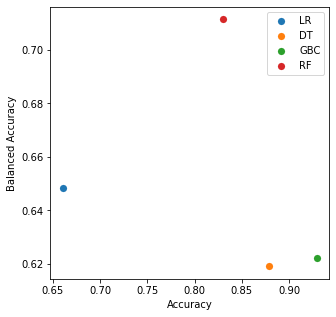

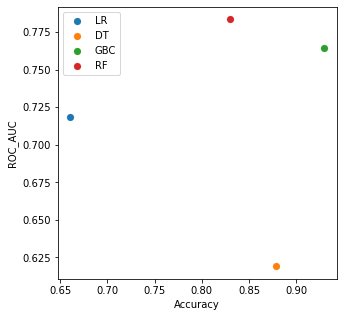

In [22]:
draw_scatter('Accuracy', 'Balanced Accuracy', performance_comparison)
draw_scatter('Accuracy', 'ROC_AUC', performance_comparison)

# Evaluating Fairness of the Models

We use the AI Fairness 360 library to compute 4 fairness metrics. We consider 'loan approval' to be a preferred outcome. Also, we consider 'Non-Hispanic Whites' to be traditionally privileged as compared to 'Non-Hispani Blacks'. Similarly, we consider 'Males' to be traditionally privileged as compared to 'Females'

Disparate Impact and Statistical Parity Difference meaure fairness in terms of the % of each group that has a preferred outcome (loan approved). Disparate impact measures ratio of un-privileged to privileged class (fairness == 1), while Statistical Parity Difference measures their difference (fairness == 0)

Equality of Opportunity measure fairness in terms of how good the models are in correctly predicting people who are in fact approved for loans (by computing the difference between the rates for privileged and unprivileged groups).  A value of 0 implies fairness.

Average Odds Difference (related to Equality of Odds) goes a step further, and measures fairness in terms of equality in predictive rates for both people approved for loans as well as people denied the mortgage. The metric is computed as the average of the differences in each rate between the two groups.

In [23]:
# fairness
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

#Bias Mitigation Techniques
from aif360.algorithms.preprocessing.reweighing import Reweighing

seed(42)


The AIF toolkit provides two ways for computing metrics. It provides a library-specific set of methods that requires the creation of BinaryLabelDataset which provides easy, direct methods for computing the fairness metrics. It also provides an interface that is compatible with the widely used Python scikit-learn APIs.

Here, we create a BinaryLabelDataset and compute the various metrics.

In [24]:
def fairness_metrics(model, X, y, prot_attr):
    pred_data = X.copy()  #X is dataframe, X_scaled is numpy array
    orig_data = X.copy()    

    y_pred = model.predict_proba(orig_data)
    y_pred = np.argmax(y_pred, axis=1)

    orig_data['target'] = y.copy()
    pred_data['target'] = y_pred
        
    # create "BinaryLabelDataset" and "BinaryLabelDatasetMetric" class instances
    orig_df = BinaryLabelDataset(df=orig_data, label_names=['target'], protected_attribute_names=[prot_attr])
    pred_df = BinaryLabelDataset(df=pred_data, label_names=['target'], protected_attribute_names=[prot_attr])

    privileged_groups = [{prot_attr: 1}]
    unprivileged_groups = [{prot_attr: 0}]
                
    classified_metric = ClassificationMetric(orig_df, 
                                                 pred_df,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
        
    # create a list and append values of the scores
    score_temp = []
    score_temp.append(classified_metric.disparate_impact())
    score_temp.append(classified_metric.statistical_parity_difference())
    score_temp.append(classified_metric.equal_opportunity_difference())
    score_temp.append(classified_metric.average_odds_difference())
    
    return score_temp

Compute and display the fairness metrics

Sensitive feature:  derived_race_ethnicity_combination


,LR,DT,GBC,RF
Disparate Impact,0.224561,0.914368,0.964192,0.776428
Statistical Parity Difference,-0.518112,-0.078519,-0.034903,-0.185399
Equal Opportunity Difference,-0.523053,-0.048124,-0.005150,-0.146806
Average Odds Difference,-0.433757,-0.076178,-0.028650,-0.150093


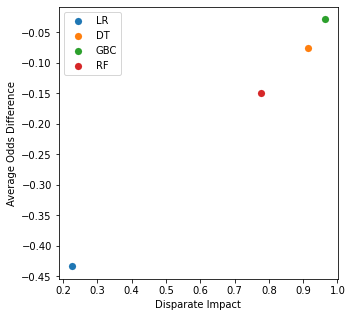

In [25]:
print('Sensitive feature: ', prot_attrs_names[0])
fairness_dict = {'LR': fairness_metrics(hmda_lr,X_test,y_test, prot_attrs_names[0]),
                    'DT': fairness_metrics(hmda_dt,X_test,y_test, prot_attrs_names[0]),
                    'GBC': fairness_metrics(hmda_gbc,X_test,y_test, prot_attrs_names[0]),
                    'RF': fairness_metrics(hmda_rf,X_test,y_test, prot_attrs_names[0])}

fairness_comparison = pd.DataFrame(fairness_dict, index = ['Disparate Impact', 'Statistical Parity Difference', 'Equal Opportunity Difference', 'Average Odds Difference'])

display(fairness_comparison)

draw_scatter('Disparate Impact', 'Average Odds Difference', fairness_comparison)


Compare performance and fairness of various models. Are the best performing models the fairest?

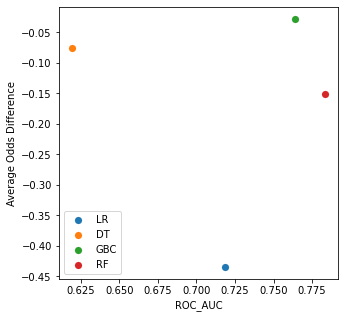

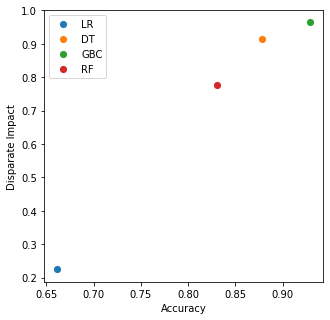

In [26]:
model_comparison = pd.concat([performance_comparison, fairness_comparison])

draw_scatter('ROC_AUC', 'Average Odds Difference', model_comparison)

draw_scatter('Accuracy', 'Disparate Impact', model_comparison)

### Bias mitigation using Reweighing (pre-processing method)

The AIF 360 toolkit includes several methods for making predicitive models 'fairer'. The methods can be broken down into three groups: 'pre-processing' methods that operate on the training data by changing the weights, labels, or features; 'in-processing' methods that address fairness during the model creation process (algorithm); and 'post-processing' methods that address fairness by making changes to the predicted labels.

Here, we show how a simple in-processing method, Reweighing' can be used to make a model fairer. This method only adjusts the weights associated with training instances, and does not make any changes to the labels or feature values.

In [27]:
seed(42)


rew_Data = X_train.copy()  #X is dataframe
rew_y_train = y_train.copy()
rew_Data['target'] = rew_y_train

# create "BinaryLabelDataset" 
rew_df = BinaryLabelDataset(df=rew_Data, label_names=['target'], protected_attribute_names=[prot_attrs_names[0]])

privileged_groups = [{prot_attrs_names[0]: 1}]
unprivileged_groups = [{prot_attrs_names[0]: 0}]

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
RW.fit(rew_df)
transf_Data = RW.transform(rew_df)
sample_weights = transf_Data.instance_weights.copy()

In [28]:
sample_weights

array([0.9942409, 0.9942409, 0.9942409, ..., 0.9942409, 0.9942409,
       0.9942409])

In [29]:
#  EXAMPLE code to show how you could do Reweighing if we were using a StandardDataset earlier instead of a Pandas dataframe
## IMPORTANT NOTE: Since the order of the columns in the 3 may not be the same, use the same data structure you 
# created the models with
# seed(42)


# privileged_groups = [{prot_attrs_names[0]: 1}]
# unprivileged_groups = [{prot_attrs_names[0]: 0}]

# RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(sd_train)
# transf_Data = RW.transform(sd_train)
# sample_weights = transf_Data.instance_weights.copy()

Since LR and RF models were quite unfair (wrt race_ethnicity), we learn models from the data modified by the Reweighing method.

In [30]:
preprocess = ColumnTransformer([("numerical_columns", StandardScaler(), input.isin(num)),
                                ("categorical_columns", 'passthrough',  ~input.isin(num) & ~input.isin(prot_attrs_names)),
                                ("fairness_columns", 'passthrough',  input.isin(prot_attrs_names))
                                ])
# Logistic Regression
rew_lr_test = Pipeline(steps=[("preprocess", preprocess), ("classifier", LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42))])
fit_params = {'classifier__sample_weight': transf_Data.instance_weights.copy()}
hmda_rew_lr_test = rew_lr_test.fit(transf_Data.features, transf_Data.labels.ravel(), **fit_params)

# Random Forest
rew_rf_test = Pipeline(steps=[("preprocess", preprocess), ("classifier", RandomForestClassifier(n_jobs=-1, max_depth=8, 
                                          n_estimators=25, class_weight='balanced', random_state=42))])
fit_params = {'classifier__sample_weight': transf_Data.instance_weights.copy()}
hmda_rew_rf_test = rew_rf_test.fit(transf_Data.features, transf_Data.labels.ravel(), **fit_params)

Compute and display fairness metrics for models after Reweighing. Are they fairer?

In [31]:
print('Sensitive feature: ', prot_attrs_names[0])
debiased_fairness_dict = {'DEB_LR': fairness_metrics(hmda_rew_lr_test,X_test,y_test, prot_attrs_names[0]),
                          'DEB_RF': fairness_metrics(hmda_rew_rf_test,X_test,y_test, prot_attrs_names[0])}

debiased_fairness_comparison = pd.DataFrame(debiased_fairness_dict, index = ['Disparate Impact', 'Statistical Parity Difference', 'Equal Opportunity Difference', 'Average Odds Difference'])

display(debiased_fairness_comparison)

Sensitive feature:  derived_race_ethnicity_combination


,DEB_LR,DEB_RF
Disparate Impact,0.929136,0.887252
Statistical Parity Difference,-0.043762,-0.093133
Equal Opportunity Difference,-0.025597,-0.054205
Average Odds Difference,-0.002185,-0.057588


How about performance?

In [32]:
debiased_performance_dict = {'DEB_LR': accuracy_metrics(hmda_rew_lr_test, X_test, y_test),
                             'DEB_RF': accuracy_metrics(hmda_rew_rf_test, X_test, y_test)}

debiased_performance_comparison = pd.DataFrame(debiased_performance_dict, index = ['Accuracy', 'Precision', 'Recall', 'F1', 'Balanced Accuracy', 'ROC_AUC', 'TN', 'FP','FN', 'TP'])

display(debiased_performance_comparison)

,DEB_LR,DEB_RF
Accuracy,0.640278,0.831579
Precision,0.949922,0.953762
Recall,0.639776,0.857105
F1,0.764594,0.902854
Balanced Accuracy,0.642666,0.710219
ROC_AUC,0.709218,0.780514
TN,1162.000000,1014.000000
FP,638.000000,786.000000
FN,6814.000000,2703.000000
TP,12102.000000,16213.000000


How do they compare to the earlier models?

In [33]:
debiased_model_comparison = pd.concat([performance_comparison, fairness_comparison])

debiased_model_comparison.insert(4,'DEB_LR',pd.concat([debiased_fairness_comparison,debiased_performance_comparison])['DEB_LR'])
debiased_model_comparison.insert(5,'DEB_RF',pd.concat([debiased_fairness_comparison,debiased_performance_comparison])['DEB_RF'])

display(debiased_model_comparison)

,LR,DT,GBC,RF,DEB_LR,DEB_RF
Accuracy,0.660987,0.878451,0.929330,0.830180,0.640278,0.831579
Precision,0.950049,0.933810,0.933052,0.954111,0.949922,0.953762
Recall,0.663618,0.933020,0.993920,0.855149,0.639776,0.857105
F1,0.781412,0.933414,0.962525,0.901924,0.764594,0.902854
Balanced Accuracy,0.648476,0.619010,0.622238,0.711463,0.642666,0.710219
ROC_AUC,0.718226,0.619018,0.764232,0.783460,0.709218,0.780514
TN,1140.000000,549.000000,451.000000,1022.000000,1162.000000,1014.000000
FP,660.000000,1251.000000,1349.000000,778.000000,638.000000,786.000000
FN,6363.000000,1267.000000,115.000000,2740.000000,6814.000000,2703.000000
TP,12553.000000,17649.000000,18801.000000,16176.000000,12102.000000,16213.000000


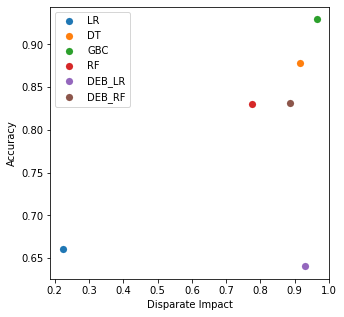

In [34]:
draw_scatter('Disparate Impact', 'Accuracy', debiased_model_comparison)

### Bias mitigation using PrejudiceRemover (in-processing method)

In [35]:
from aif360.algorithms.inprocessing import PrejudiceRemover
pr_m = PrejudiceRemover(sensitive_attr='derived_race_ethnicity_combination', eta=25.0)

input = pd.Index(sd_train.feature_names)

pr_sd_train = sd_train.copy()

preprocess = ColumnTransformer([("numerical_columns", StandardScaler(), input.isin(num)),
                                ("categorical_columns", 'passthrough',  ~input.isin(num) & ~input.isin(prot_attrs_names)),
                                ("fairness_columns", 'passthrough',  input.isin(prot_attrs_names))
                                ])
lr = Pipeline(steps=[("preprocess", preprocess)])
pr_sd_train.features = lr.fit_transform(pr_sd_train.features)
pr_model = pr_m.fit(pr_sd_train)

In [36]:
pr_sd_test = sd_test.copy()
pr_sd_test.features = lr.fit_transform(pr_sd_test.features)
y_val_pred_prob = pr_model.predict(pr_sd_test).scores
pos_ind = 0
y_val_pred = (y_val_pred_prob[:, pos_ind] > 0.5).astype(np.float64)
pr_dataset_pred = pr_sd_test.copy()
pr_dataset_pred.labels = y_val_pred
metric = ClassificationMetric(
        pr_sd_test, pr_dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
print('Disparate impact: ', metric.disparate_impact())
print('Balanced accuracy: ', (metric.true_positive_rate() + metric.true_negative_rate()) / 2)
print('Accuracy: ', metric.accuracy())

Disparate impact:  1.0001025588431363
Balanced accuracy:  0.4999471347007824
Accuracy:  0.9130140953852095


# Evaluating Explainability of the Models

The opensource AI Explainability 360 (AIX360) toolkit provides several methods for exploring the explainability/interpretability of AI models (direct as well as post hoc, and local as well as global) as well as metrics for measuring the quality of such explanations. It also provides interfaces to LIME and SHAP, two widely used local, post-hoc explanation methods.

We explore the use of one such metric, Faithfulness, to evaluate the quality of local explanations produced by the learnt models. We use LIME to produce the underlying explanations. This metric evaluates the correlation between the importance assigned by the interpretability algorithm
to attributes and the effect of each of the attributes on the performance of the predictive model (higher the weight, greater the impact implies higher faithfulness of explanations).

We also explore the use of LIME and SHAP to compare explanations produced by the various models on the same cases.

In [37]:

# explainability
import lime 
from lime.lime_tabular import LimeTabularExplainer
from aix360.metrics import faithfulness_metric

# Importing shap KernelExplainer (aix360 wrapper for Shap)
from aix360.algorithms.shap import KernelExplainer

# the following import is required for access to shap plotting functions and datasets
import shap

shap.initjs()

seed(42)


For faithfulness, local explanations are generated by LIME for a sample of cases. Faithfulness is computed for each sample and averaged over them.

In [38]:
def lime_explainability(explainer, model, X, y, ncases, random_state=42):  
    st = time()

    Xdata = X.copy()
    if ncases > Xdata.shape[0]:
        ncases = Xdata.shape[0]
    samples = Xdata.sample(ncases, random_state=random_state)
    
    samples = samples.values        

    mon = np.zeros(ncases)
    fait = np.zeros(ncases)
    base = np.zeros(samples.shape[1])
    #define num_features, look at top_labels
    for i in range(ncases):

        y_pred = model.predict_proba(samples[i].reshape(1, -1))   
        y_pred = np.argmax(y_pred, axis=1)
            
        predicted_class = y_pred[0] * 1.0
        exp = explainer.explain_instance(samples[i], model.predict_proba, num_features=20, top_labels=2, num_samples=500)
        try:
            le = exp.local_exp[predicted_class]
        except:
            print('exception thrown in explainability')
            le = exp.local_exp[0]
        m = exp.as_map()

        x = samples[i]
        coefs = np.zeros(x.shape[0])

        for v in le:
            coefs[v[0]] = v[1]
                
        fait[i] = faithfulness_metric(model, samples[i], coefs, base)


    # create a list and append values of the scores
    score_temp = []
    score_temp.append(np.nanmean(fait))
    score_temp.append(np.nanstd(fait, ddof=1))

    from scipy.stats import sem
    score_temp.append(sem(fait, nan_policy='omit'))
    
    tm = round((time()-st)/60,2)
    print('Faithfulness time: ', tm)
    
    return score_temp

Create a LIME explainer and compute/display avg. faithfulness (and std. dev and std. error) for the various models.

In [39]:
explainer = LimeTabularExplainer(X_train.values,feature_names=X_train.columns, 
                                 class_names=['0','1'], discretize_continuous=True)


In [40]:
num_of_cases_to_explain = 20


explainability_dict = {'LR': lime_explainability(explainer, hmda_lr, X_test, y_test, num_of_cases_to_explain),
                    'DT': lime_explainability(explainer, hmda_dt, X_test, y_test, num_of_cases_to_explain),
                    'GBC': lime_explainability(explainer, hmda_gbc, X_test, y_test, num_of_cases_to_explain),
                    'RF': lime_explainability(explainer, hmda_rf, X_test, y_test, 5)}

explainability_comparison = pd.DataFrame(explainability_dict, index = ['Faithfulness', 'Faithfulness (std dev.)', 'Faithfulness (std err.)'])

display(explainability_comparison)

Faithfulness time:  0.19
Faithfulness time:  0.18
Faithfulness time:  0.19
Faithfulness time:  0.43


,LR,DT,GBC,RF
Faithfulness,0.125477,0.004186,0.005456,0.020061
Faithfulness (std dev.),0.113981,0.236212,0.164968,0.109099
Faithfulness (std err.),0.025487,0.074697,0.036888,0.048791


Compare model explainability with performance and fairness. Do best performing models also have the best explainability?

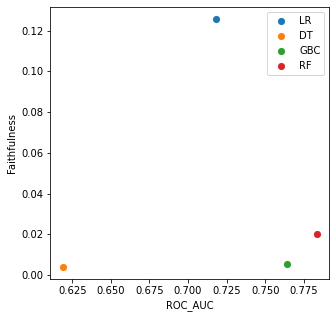

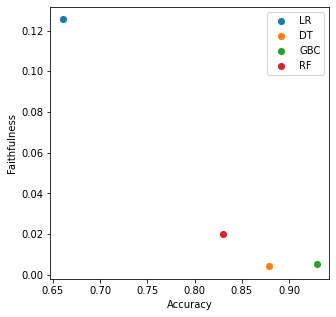

In [41]:
model_comparison = pd.concat([performance_comparison, fairness_comparison, explainability_comparison])

draw_scatter('ROC_AUC', 'Faithfulness', model_comparison)

draw_scatter('Accuracy', 'Faithfulness', model_comparison)

Let us see how LIME explanations differ for the same case for different models

actual label:  [1.]
[[0.44794928 0.55205072]]
predicted class:  1.0


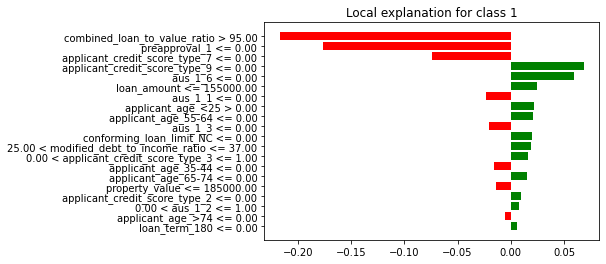

In [42]:
exp = explainer.explain_instance(X_test.iloc[100,:], hmda_rf.predict_proba, num_features=20, top_labels=2, num_samples=500)
print('actual label: ',y_test.values[0])
y_pred = hmda_rf.predict_proba([X_test.iloc[100,:]])   
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)

predicted_class = y_pred[0] * 1.0
print('predicted class: ', predicted_class)

exp.as_pyplot_figure()
plt.show()


actual label:  [1.]
[[0.07644376 0.92355624]]
predicted class:  1.0


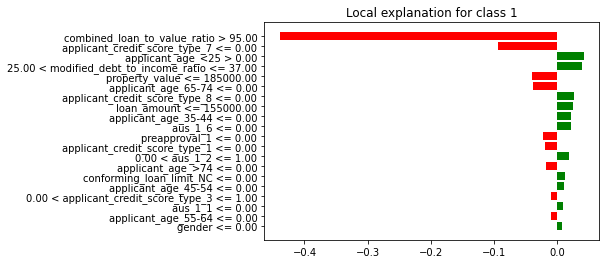

In [43]:
exp = explainer.explain_instance(X_test.iloc[100,:], hmda_gbc.predict_proba, num_features=20, top_labels=2, num_samples=500)
print('actual label: ',y_test.values[0])
y_pred = hmda_gbc.predict_proba([X_test.iloc[100,:]])   
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)

predicted_class = y_pred[0] * 1.0
print('predicted class: ', predicted_class)


exp.as_pyplot_figure()
plt.show()


How about SHAP?

In [44]:
shapexplainer = KernelExplainer(hmda_lr.predict_proba, shap.sample(X_train, 100), feature_names=X_train.columns) #, output_names=['Loan not approved', 'Loan approved'])
print(type(shapexplainer))

<class 'aix360.algorithms.shap.shap_wrapper.KernelExplainer'>


In [45]:
# aix360 style for explaining input instances
shap_values = shapexplainer.explain_instance(X_test.iloc[100,:])
shap.force_plot(shapexplainer.explainer.expected_value[1], shap_values[1], X_test.iloc[100,:], feature_names=X_train.columns) #, out_names=['Loan not approved', 'Loan approved'])

Note the fact that for LR model, 'race/ethnicity = 0 i.e. Non Hispanic Black' strongly 'reduces' probability of getting a mortgage. This explains why the LR model was found to be so 'unfair' when evaluated for fairness earlier.

Explore feature importance over a set of cases, as evaluated by SHAP

In [46]:
shap_sample = shap.sample(X_test, 100)
shap_values = shapexplainer.explain_instance(shap_sample)


  0%|          | 0/100 [00:00<?, ?it/s]

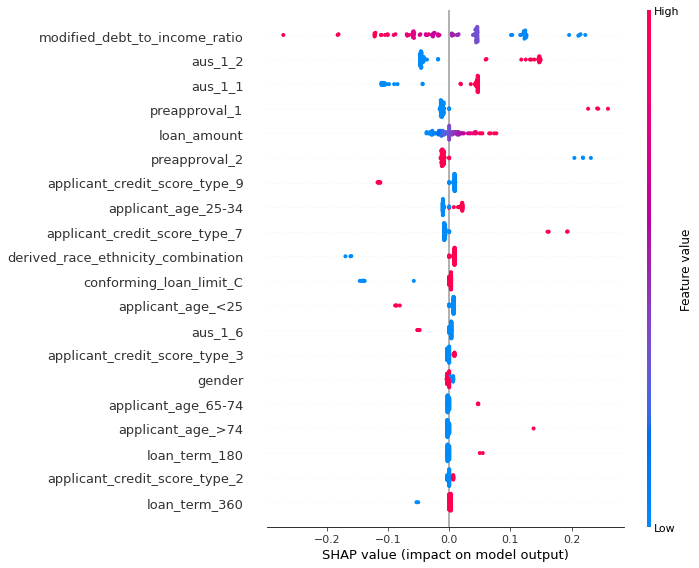

In [47]:
shap.summary_plot(shap_values[1], shap_sample)

# Consolidated Results of Comparing Models Along Multiple Dimensions

All the metrics explored for the various models are now displayed together. For most metrics, the value/model that is the best is shown in green. For privacy metrics, the value/model showing highest risk is shown in red. 

The table lets one get a big picture at a glance...is the same model the best for all metrics? Choice for a model may depend on business, legal, and ethical requirements, and a model that is the most accurate or the most fair may not be the best for a given situation. Trade-offs are often required - for example, can a less accurate model be acceptable if it is more explainable?

In [48]:
model_comparison = pd.concat([performance_comparison, fairness_comparison, explainability_comparison])
model_comparison.insert(4,'DEB_LR',pd.concat([debiased_fairness_comparison,debiased_performance_comparison])['DEB_LR'])
model_comparison.insert(5,'DEB_RF',pd.concat([debiased_fairness_comparison,debiased_performance_comparison])['DEB_RF'])

display(model_comparison.style.\
        highlight_max(color = 'lightgreen', axis = 1, subset=pd.IndexSlice[['Accuracy', 'Precision', 'Recall', 'F1','Balanced Accuracy', 'ROC_AUC',
                                                                            'TN', 'TP','Disparate Impact','Faithfulness',],:]).\
        highlight_max(color = 'lightgreen', axis = 1, subset=pd.IndexSlice[['Statistical Parity Difference', 'Equal Opportunity Difference','Average Odds Difference'],:]).\
        highlight_min(color = 'lightgreen', axis = 1, subset=pd.IndexSlice[['FP', 'FN'],:]))

,LR,DT,GBC,RF,DEB_LR,DEB_RF
Accuracy,0.660987,0.878451,0.929330,0.830180,0.640278,0.831579
Precision,0.950049,0.933810,0.933052,0.954111,0.949922,0.953762
Recall,0.663618,0.933020,0.993920,0.855149,0.639776,0.857105
F1,0.781412,0.933414,0.962525,0.901924,0.764594,0.902854
Balanced Accuracy,0.648476,0.619010,0.622238,0.711463,0.642666,0.710219
ROC_AUC,0.718226,0.619018,0.764232,0.783460,0.709218,0.780514
TN,1140.000000,549.000000,451.000000,1022.000000,1162.000000,1014.000000
FP,660.000000,1251.000000,1349.000000,778.000000,638.000000,786.000000
FN,6363.000000,1267.000000,115.000000,2740.000000,6814.000000,2703.000000
TP,12553.000000,17649.000000,18801.000000,16176.000000,12102.000000,16213.000000
